# Solving combinatorial optimization problems using QAOA

In this tutorial, we will:
- introduce combinatorial optimization problems;
- explain approximate optimization algorithms;
- explain how the Quantum Approximate Optimization Algorithm (QAOA) works; and
- run a simple example on a simulator or a real quantum system.

## Combinatorial Optimization Problem

Combinatorial optimization problems involve finding an optimal object out of a finite set of objects. We would focus on problems that involve 
finding "optimal" bit strings composed of 0's and 1's among a finite set of bit strings. One such problem corresponding to a graph is the Max-Cut problem. 

### Max-Cut problem
A Max-Cut problem involves partitioning nodes of a graph into two sets, such that the number of edges between the sets is maximum. The example below has a graph with four nodes and some ways of partitioning it into two sets, "red" and "blue" is shown.

![](images/qaoa_maxcut.svg)

For 5 nodes, as each node can be assigned to either the "red" or "blue" sets, there are $2^4=32$ possible assignments, out of which we have to find one that gives maximum number of edges between the sets "red" and "blue". The number of such edges between two sets in the figure, as we go from left to right, are 0, 2, 2, and 4. We can see, after enumerating all possible $2^4=32$ assignments, that the rightmost figure is the assignment that gives the maximum number of edges between the two sets. Hence if we encode "red" as 0 and "blue" as 1, the bit strings "0101" and "1010" that represent the assignment of nodes to either set are the solutions.   

As you may have realized, as the number of nodes in the graph increases, the number of possible assignments 
that you have to examine to find the solution increases exponentially.

## QAOA

QAOA (Quantum Approximate Optimization Algorithm), introduced by Farhi et al. [1], is a quantum algorithm that attempts to 
solve such combinatorial problems.<br> 

It is a variational algorithm that uses a unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ characterized by the parameters 
$(\boldsymbol{\beta}, \boldsymbol{\gamma})$ to prepare a quantum state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$. 
The goal of the algorithm
is to find optimal parameters `{latex} (\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}})` such that the 
quantum state `{latex} \lvert \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle` encodes the solution to the problem. 

The unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ has a specific form and is composed of two unitaries 
$U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ and $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$
where $H_B$ is the mixing Hamiltonian and $H_P$ is the problem Hamiltonian. Such a choice of unitary drives its inspiration 
from a related scheme called quantum annealing.

The state is prepared by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that 

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle$$

where $\lvert \psi_0 \rangle$ is a suitable initial state. 

We will demonstrate these steps using the Max-Cut problem discussed above. For that, we would first define
the underlying graph of the problem as shown above.

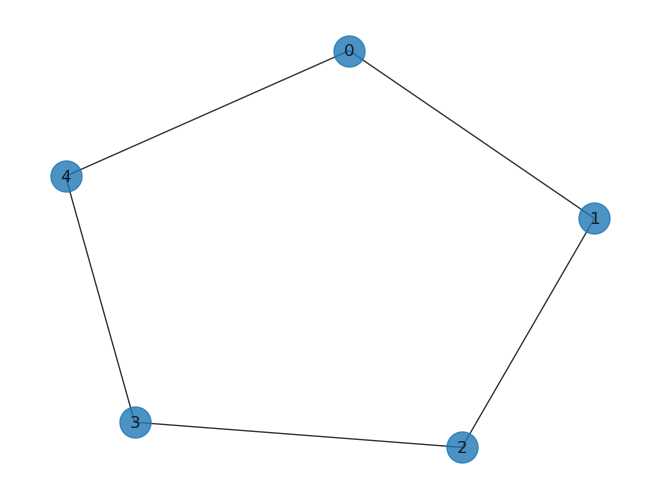

In [76]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3,4])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4),(4,0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

The problem Hamiltonian specific to the Max-Cut problem up to a constant here is:

$$
H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + 
        \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) +
        \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_4\big) +
        \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big) +
          \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_3 \otimes Z_4\big)
$$

To construct such a Hamiltonian for a problem, one needs to follow a few steps that we'll cover in later sections of this page.

The mixer Hamiltonian $H_B$ is usually of the form:

$$
H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3  \otimes I_4 \big) + 
      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3  \otimes I_4 \big) +
      \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3  \otimes I_4\big) +
      \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \otimes I_4 \big)+
      \big(I_0 \otimes I_1 \otimes I_2  \otimes I_3 \otimes X_4 \big)
$$

As individual terms in the summation of $H_P$ and $H_B$ both commute, we can write the unitaries as:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3} e^{-i\beta X_4}.$$

Notice that each term in the product above corresponds to an X-rotation on each qubit. And we can write $U(H_P)$ as:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_4}e^{-i \gamma Z_0 Z_4}$$

Let's now examine what the circuits of the two unitaries look like. 

### The Mixing Unitary

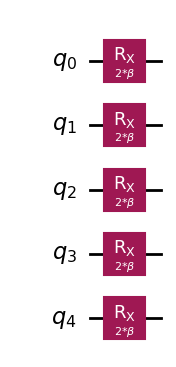

In [77]:
from qiskit import QuantumCircuit , transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 5

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw("mpl")

### The Problem Unitary

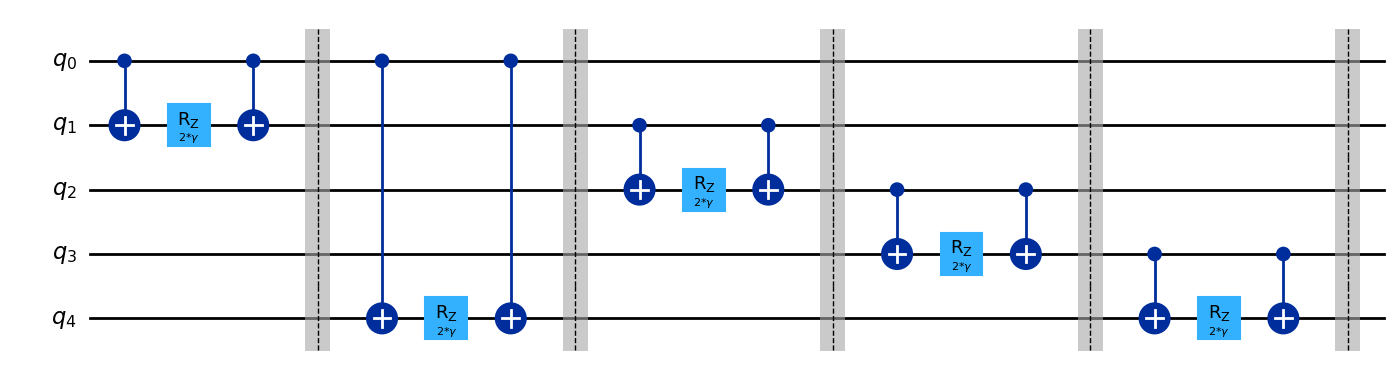

In [78]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw("mpl")

### The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

Such a state, when the number of qubits is 4 ($n=4$), can be prepared by applying Hadamard gates starting from an all-zero state as shown in 
the circuit below. 

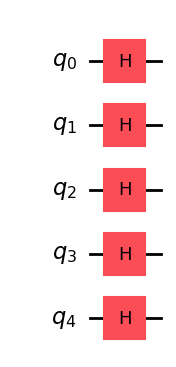

In [79]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw("mpl")

### The QAOA circuit

So far, we have seen that the preparation of a quantum state during QAOA is composed of three elements:
- Preparing an initial state
- Applying the unitary `{latex} U(H_P) = e^{-i \gamma H_P}` corresponding to the problem Hamiltonian
- Then, applying the mixing unitary `{latex} U(H_B) = e^{-i \beta H_B}`

Let's see what it looks like for the example problem:

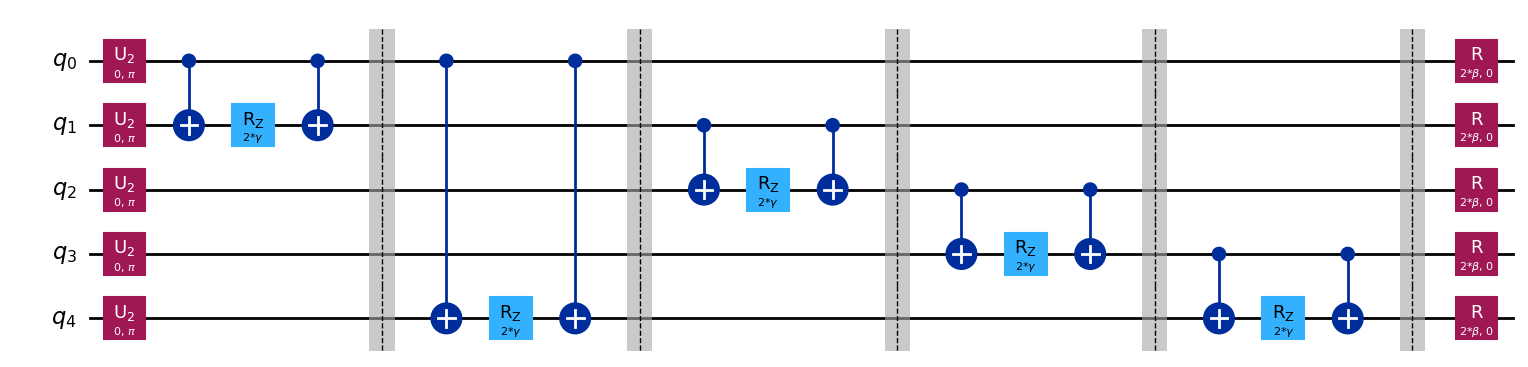

In [80]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw("mpl")


1. Initialize $\boldsymbol{\beta}$ and $\boldsymbol{\gamma}$ to suitable real values.
2. Repeat until some suitable convergence criteria is met:
    1. Prepare the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ using the QAOA circuit
    2. Measure the state in standard basis
    3. Compute $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ 
    4. Find new set of parameters `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})` using a classical optimization algorithm
    5. Set current parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ equal to the new parameters 
      `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})`

The code below implements the steps mentioned above.

In [81]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on
#  the chosen backend

def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    # Create simulator backend
    backend = AerSimulator()

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)  # Your QAOA circuit function
        # Execute the circuit on the simulator
        counts = execute(qc, backend=backend, shots=shots, seed_simulator=10).result().get_counts()
        # Compute the expectation value
        return compute_expectation(counts, graph)

    return execute_circ

def get_expectation(graph, shots=512):
    """Return a function that computes expectation for given parameters."""
    backend = AerSimulator()

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        # Transpile before running
        compiled_circ = transpile(qc, backend)
        result = backend.run(compiled_circ, shots=shots, seed_simulator=10).result()
        counts = result.get_counts()
        return compute_expectation(counts, graph)

    return execute_circ



In [82]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.76171875
       x: [ 1.982e+00  1.165e+00]
    nfev: 32
   maxcv: 0.0

Note that different choices of classical optimizers are present in Qiskit. We choose [COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py) as our classical optimization algorithm here.

### Analyzing the result

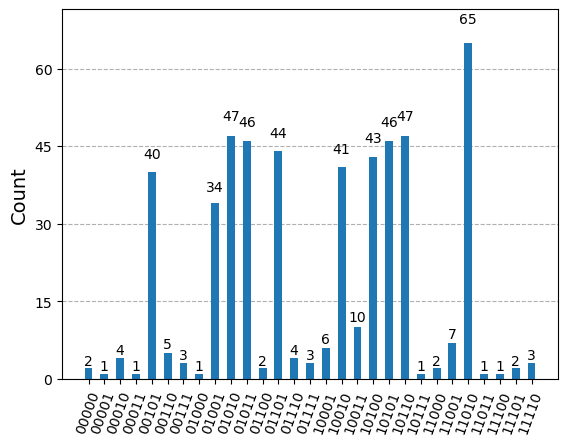

In [83]:


# Run on the simulator
result = backend.run(compiled_circ, shots=512, seed_simulator=10).result()
counts = result.get_counts()

# Plot results
plot_histogram(counts)


# Measurement Histogram Description

This figure is a **histogram (bar chart) of bitstring measurement outcomes** from a quantum circuit simulation or execution on hardware.  

- **X-axis (horizontal):** The possible **bitstrings** (e.g. `00000`, `01001`, `11101`) corresponding to measurement results of a multi-qubit quantum register.  
- **Y-axis (vertical):** The **count** (number of times) each bitstring was observed in repeated circuit runs (shots).  

---

## Observations
1. The distribution is **not uniform**: some bitstrings occur far more often than others.  
   - For example, `11101` appears **65 times**, making it the most frequent outcome.  
   - Bitstrings like `00001`, `00110`, `11100` appear only **once** or **twice**, showing very low probability.  

2. Several states cluster around **~40–47 counts** (e.g. `00101`, `01000`, `01001`, `01100`, `10001`, `10100`).  
   This suggests the quantum circuit has a structure that favors these outcomes.  

3. Some **rare states** appear sporadically, with counts under 5, possibly due to **quantum interference, gate errors, or noise**.  

---

## Interpretation
This histogram represents the **probability distribution** over measurement outcomes of a quantum state after running the circuit multiple times.  
The higher the bar, the more likely that state is in the quantum superposition.  

In other words, the circuit does not produce a single deterministic result but a **distribution of possible results**, consistent with quantum mechanics.  


## References<a id="references"></a>
1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)